# Artificial Type Dataset Profiling

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

The dataset is defined to be 15GB.

The sample count varies to showcase differences in performance with the same amount of data.

Every experiment was done 5 times, with two datatypes: `uint8` and `float32`

In [1]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import matplotlib.patches as mpatches

from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

local_fig_dir = "misc"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

### X.1 Calculation on how many samples we need for differing sample storage consumptions

Calculating the float32 ones, as we want the sample counts to be natural numbers.

To calculate the uint8 sample counts, we need to multiply the the float32 ones times 4.

In [2]:
base_vector = 2500 # defined in the type_demo.py
float32_in_mb = 4 / 1000**2 # 32bit -> 4 byte
min_sample_size_mb = base_vector * float32_in_mb # smallest possible sample storage consumption
max_dataset_size_mb = 15 * 1000.0 # maximum total storage consumption in MB

sample_dict = {
    "vector_lines": [],
    "vector_lines_uint8": [],
    "sample_storage_consumption_mb": [],
    "sample_count": []
}

for count in range(0,12):
    
    vector_lines = 2**count
    sample_storage_consumption_mb = min_sample_size_mb * vector_lines
    sample_count = int(max_dataset_size_mb / sample_storage_consumption_mb)
    
    sample_dict["vector_lines"].append(vector_lines)
    sample_dict["vector_lines_uint8"].append(vector_lines * 4)
    sample_dict["sample_storage_consumption_mb"].append(sample_storage_consumption_mb)
    sample_dict["sample_count"].append(sample_count)

pd.DataFrame(sample_dict)

,vector_lines,vector_lines_uint8,sample_storage_consumption_mb,sample_count
0,1,4,0.01,1500000
1,2,8,0.02,750000
2,4,16,0.04,375000
3,8,32,0.08,187500
4,16,64,0.16,93750
5,32,128,0.32,46875
6,64,256,0.64,23437
7,128,512,1.28,11718
8,256,1024,2.56,5859
9,512,2048,5.12,2929


### X.2 Some helper functions

In [3]:
def read_datatype_log(path_to_cum_df, path_to_cum_dstat_df, datatype):
    '''Filter the type cumulative dataframes
    For easier evaluation, we drop the unnecessary columns.
    '''
    analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                     , path_to_cum_df = path_to_cum_df)
    cum_dstat_df = analysis.to_cum_dstat_df()
    cum_df       = analysis.to_cum_df()
    # need to sort the strategies for some reason as they are not ascending
    cum_df = cum_df.sort_values(by='split_name')
    strategies   = list(cum_df.split_name.unique())
    # add the average storage consumption per sample
    cum_df["per_sample_size_MB"] = cum_df["shard_cum_size_MB"] / cum_df["sample_count"]
    # add the datatype as column to each df
    cum_df["dtype"] = datatype
    cum_dstat_df["dtype"] = datatype
    
    # delete not needed columns
    cum_df = cum_df.drop('shard_count', 1)
    cum_df = cum_df.drop('thread_count', 1)
    #cum_df = cum_df.drop('runs_count', 1)
    #cum_df = cum_df.drop('runs_total', 1)
    cum_df = cum_df.drop('compression_type', 1)
    cum_df = cum_df.drop('storage_type', 1)
    cum_df = cum_df.drop('throughput_sps', 1)
    cum_df = cum_df.drop('split_name', 1)
    
    cum_dstat_df = cum_dstat_df.drop('shard_count', 1)
    cum_dstat_df = cum_dstat_df.drop('thread_count', 1)
    #cum_dstat_df = cum_dstat_df.drop('run', 1)
    cum_dstat_df = cum_dstat_df.drop('compression_type', 1)
    cum_dstat_df = cum_dstat_df.drop('storage_type', 1)
    
    return cum_df, cum_dstat_df

def extract_online_processing_frames(sample_count, df, dstat_df):
    '''Extracts the online processing time from the dataframe.
    Filters the dstat_df by that online processing time.
    '''        
    max_offline_processing_time_s = df.query(
        f"sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = dstat_df.query(
        f"sample_count=='{sample_count}' and rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df


def return_online_df(df, dstat_df):
    '''Returns the dstat dataframe filteredy by online processing time
    Also prints a summary about the network reads
    '''
    sample_counts = df.sample_count.unique()
    frames = [extract_online_processing_frames(sample_count=sample_count
                                              ,df=df
                                              ,dstat_df=dstat_df) for sample_count in sample_counts]
    online_dstat_df = pd.concat(frames)
    
    for sample_count in np.sort(df.sample_count.unique()):
    
        avg_online_processing_time = df.query(
            f"sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
        print("---------------------------------------")
        print(f"-- {sample_count} Network Read in MB/s --")
        print(f"-- {sample_count} Online Processing time: {int(avg_online_processing_time)}")
    
        temp_df = online_dstat_df.query(f"sample_count=='{sample_count}'")
        print(temp_df.describe()["net_read_mbs"])

    return online_dstat_df

# Read Logs

In [4]:
log_path = "/logs"
uint_path = f"{}
path_to_uint8_cum_df = f"{home_path}/uint8-caching/type-uint8_caching_threads-8_cum-df.csv"
path_to_uint8_cum_dstat_df = f"{home_path}/uint8-caching/type-uint8_caching_threads-8_cum-dstat-df.csv"
path_to_float32_cum_df = f"{home_path}/float32-caching/type-float32_caching_threads-8_cum-df.csv"
path_to_float32_cum_dstat_df = f"{home_path}/float32-caching/type-float32_caching_threads-8_cum-dstat-df.csv"

uint8_dtype = "uint8"
float32_dtype = "float32"

cum_uint8_sys_df, cum_uint8_sys_dstat_df = read_datatype_log(path_to_cum_df = path_to_uint8_cum_df
                                                   , path_to_cum_dstat_df = path_to_uint8_cum_dstat_df
                                                   , datatype = uint8_dtype )
cum_float32_sys_df, cum_float32_sys_dstat_df = read_datatype_log(path_to_cum_df = path_to_float32_cum_df
                                                   , path_to_cum_dstat_df = path_to_float32_cum_dstat_df
                                                   , datatype = float32_dtype )
strategies_renamed = ["read-dataset"]
cum_summary_df = pd.concat([cum_uint8_sys_df, cum_float32_sys_df])

In [5]:
cum_float32_sys_df.query("runs_count==0").sort_values(by="sample_count").groupby(by="sample_count").mean()

,offline_processing_and_save_time_s,shard_cum_size_MB,online_processing_time_s,runs_count,runs_total,per_sample_size_MB
sample_count,,,,,,
732,64.669044,14991.408203,15.016246,0,3,20.480066
1464,61.127987,14991.457031,14.687474,0,3,10.240066
2929,61.343204,14996.672852,15.995178,0,3,5.120066
5859,64.635315,14999.426758,16.715321,0,3,2.560066
11718,68.964546,14999.743164,19.991917,0,3,1.280060
23437,74.809402,15001.062500,20.571840,0,3,0.640059
46875,92.617775,15002.765625,21.065947,0,3,0.320059
93750,136.141037,15005.531250,25.253662,0,3,0.160059
187500,256.973877,15011.062500,32.638649,0,3,0.080059


In [6]:
throughput_20mb = cum_float32_sys_df.query("runs_count==0 and sample_count==732").mean()["online_processing_time_s"]
throughput_001mb = cum_float32_sys_df.query("runs_count==0 and sample_count==1500000").mean()["online_processing_time_s"]
factor = throughput_001mb / throughput_20mb
print(f"> 20MB faster than 0.01MB by {factor}")

> 20MB faster than 0.01MB by 11.555101956569025


In [7]:
cum_uint8_sys_df.query("runs_count==0").sort_values(by="sample_count").groupby(by="sample_count").mean()

,offline_processing_and_save_time_s,shard_cum_size_MB,online_processing_time_s,runs_count,runs_total,per_sample_size_MB
sample_count,,,,,,
732,53.072235,14991.408203,16.121746,0,3,20.480066
1464,53.362492,14991.457031,15.436110,0,3,10.240066
2929,57.492496,14996.672852,16.679171,0,3,5.120066
5859,63.328735,14999.426758,18.512157,0,3,2.560066
11718,50.681232,14999.743164,20.220896,0,3,1.280060
23437,56.864815,15001.085938,18.840643,0,3,0.640060
46875,83.320076,15002.812500,21.212185,0,3,0.320060
93750,148.728302,15005.531250,25.831739,0,3,0.160059
187500,274.509583,15011.062500,32.081200,0,3,0.080059


### 1. Online processing time for `uint8` and `float32` for epoch 0

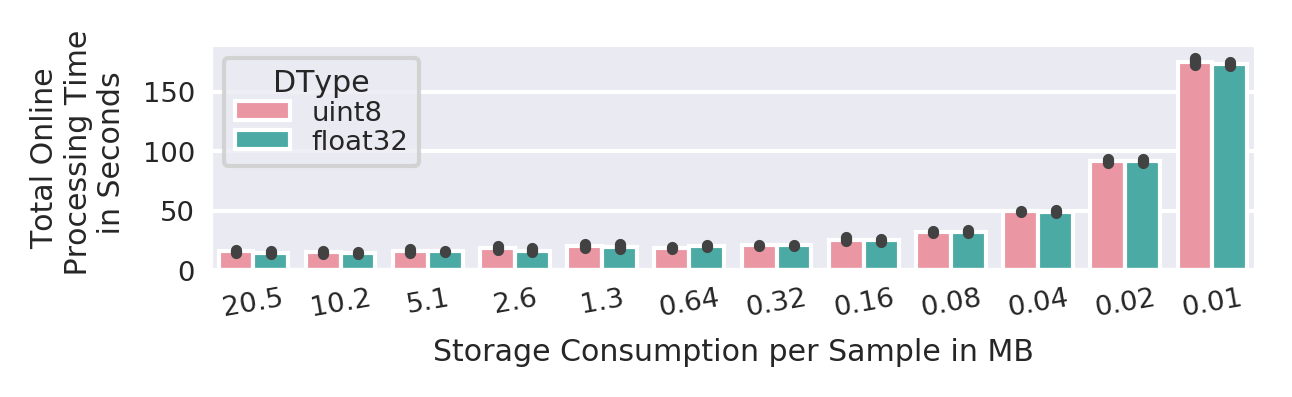

In [8]:
samples_palette = sns.color_palette("icefire", 1)
sns.set(palette=samples_palette, font_scale=0.6)

storage_consumption_per_samples = list(cum_summary_df.query("runs_count==0") \
                                                    .groupby(by='sample_count') \
                                                    .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)
sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]
 
    
plt.figure(figsize=(4.5,1))
plot = sns.barplot(
    x="sample_count"
   ,y="online_processing_time_s"
   ,hue="dtype"
   ,data=cum_summary_df.query("runs_count==0"))

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-2.5)
plot.tick_params(axis='y', which='major', pad=-2.5)
plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online\n Processing Time\n in Seconds")
plot.set(ylim=(0, 190))
#show_values_on_bars(plot, h_v="v", space=10, rotation=15)
plot.legend(title="DType", ncol=1, labelspacing=0.1)
save_fig("artificial-dataset")

[(0, 190)]

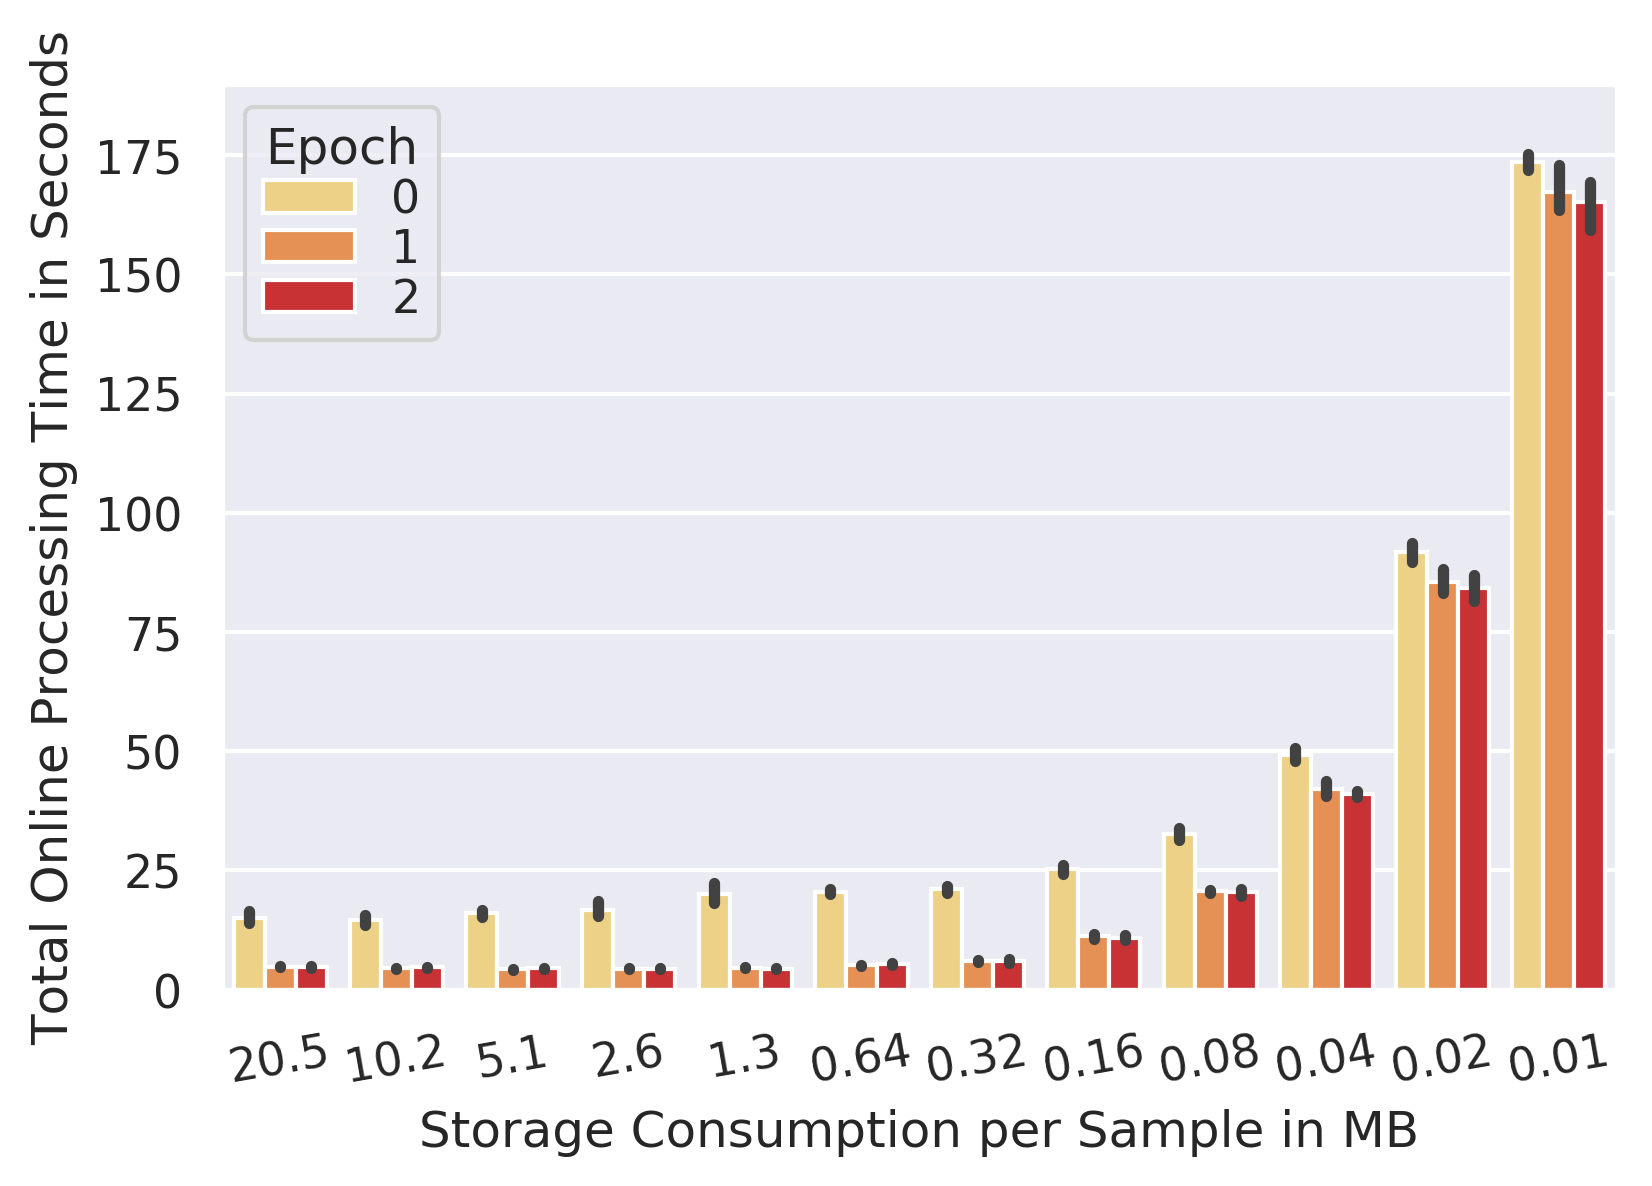

In [9]:
sns.set(palette=epoch_palette)

storage_consumption_per_samples = list(cum_summary_df.query("runs_count==0") \
                                                     .groupby(by='sample_count') \
                                                     .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)
    
sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]

plot = sns.barplot(
    x="sample_count"
   ,y="online_processing_time_s"
   ,hue="runs_count"
   ,data=cum_summary_df.query("dtype=='float32'").sort_values(by='sample_count', ascending=True))

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online Processing Time in Seconds")
plot.legend(title="Epoch", ncol=1, labelspacing=0.1)#, loc=(0.2,0.7))
#show_values_on_bars(plot, h_v="v", space=15, rotation=15, round_to=2)
 #                  additional_space=[0,-8,2,-8,2,-8,0,-6,0,0,0,0])
plot.set(ylim=(0, 190))
#save_fig("artificial-dataset-float-caching")

In [10]:
e1_system_level_caching_online_processing_time_s_df = cum_summary_df.query("dtype=='float32' and runs_count==1").sort_values(by='sample_count', ascending=True).groupby(by="sample_count").mean()["online_processing_time_s"]
e1_system_level_caching_online_processing_time_s_df

sample_count
732          4.817324
1464         4.463100
2929         4.274098
5859         4.404733
11718        4.599822
23437        5.167854
46875        5.964258
93750       11.200801
187500      20.670221
375000      42.168388
750000      85.478348
1500000    167.275436
Name: online_processing_time_s, dtype: float32

### 3. CPU Utilization for each sample size

In [11]:
def extract_cpu_online_processing_time(sample_count, df, dstat_df, run):
    '''
    '''
    threads = 8    
    
    max_offline_processing_time_s = df.query(
        f"sample_count=={sample_count} and runs_count=={run}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = dstat_df.query(
        f"sample_count=={sample_count} \
        and run=={run} and rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','sample_count']]

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'sample_count': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(sample_count, usr, sys, idle, wait):
        cpu_dict['sample_count'] += [sample_count]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for sample_count in sample_counts:
        describe_df = df.query(f"sample_count=='{sample_count}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['sample_count'] = sample_count
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(sample_count=sample_count, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
        #display(describe_df)

    return pd.DataFrame(cpu_dict)
    
df = cum_float32_df
dstat_df = cum_float32_dstat_df
run = 0
# extract all sample counts
sample_counts = df.sample_count.unique()
# extract the cpu logs for each sample count
frames = [extract_cpu_online_processing_time(sample_count=sample_count,df=df,dstat_df=dstat_df,run=run)
            for sample_count in sample_counts]
# create a nice dataframe from them
online_cpu_df = pd.concat(frames)
# create a cumulative representation of the cpu time (needed for a stacked barplot)
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)

# colors
green1 = "#5AC45C" # cpu usr
green2 = "#acf4a3" # cpu sys
grey = "#8c8c9f" # cpu idle
red = "#f45252" # cpu wait

# reverse order to show the "smaller" plots
bar4 = sns.barplot(x="sample_count",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="sample_count",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="sample_count",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="sample_count",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

# extract nice looking labels
storage_consumption_per_samples = list(cum_summary_df.query("runs_count==0") \
                                                     .groupby(by='sample_count') \
                                                     .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)

sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

NameError: name 'cum_float32_df' is not defined

## 4. Application Caching Logs

In [16]:
home_path = "../logs/type-logs/float32-application-caching"
path_to_float32_cum_df = f"{home_path}/type-float32_application-caching_threads-8_cum-df.csv"
path_to_float32_cum_dstat_df = f"{home_path}/type-float32_application-caching_threads-8_cum-dstat-df.csv"

float32_dtype = "float32"

cum_float32_app_df, cum_float32_app_dstat_df = read_datatype_log(path_to_cum_df = path_to_float32_cum_df
                                                   , path_to_cum_dstat_df = path_to_float32_cum_dstat_df
                                                   , datatype = float32_dtype )
strategies_renamed = ["read-dataset"]
#cum_summary_df = pd.concat([cum_uint8_df, cum_float32_df])
#cum_summary_df = pd.concat([cum_float32_df])
cum_float32_app_df = cum_float32_app_df.sort_values(by=["sample_count"])
cum_float32_app_df

,offline_processing_and_save_time_s,shard_cum_size_MB,sample_count,online_processing_time_s,runs_count,runs_total,ueid,creation_timestamp,per_sample_size_MB,dtype
59,55.668171,14991.408203,732,0.071983,0,1,57a869,2021-10-20-23:50:53,20.480066,float32
11,66.107964,14991.408203,732,0.076406,0,1,d84e4e,2021-10-20-18:34:12,20.480066,float32
35,59.636448,14991.408203,732,0.067079,0,1,f2c477,2021-10-20-21:11:46,20.480066,float32
23,59.114388,14991.408203,732,0.067825,0,1,56908d,2021-10-20-19:53:42,20.480066,float32
47,60.261730,14991.408203,732,0.088944,0,1,066adb,2021-10-20-22:32:35,20.480066,float32
58,57.398109,14991.457031,1464,0.239599,0,1,f4d6c8,2021-10-20-23:49:37,10.240066,float32
10,63.910767,14991.457031,1464,0.154454,0,1,4eebcb,2021-10-20-18:32:50,10.240066,float32
46,63.295403,14991.457031,1464,0.187344,0,1,bb4381,2021-10-20-22:31:13,10.240066,float32
22,61.248528,14991.457031,1464,0.131790,0,1,fb32c3,2021-10-20-19:52:23,10.240066,float32
34,56.707344,14991.457031,1464,0.132399,0,1,df2454,2021-10-20-21:10:31,10.240066,float32


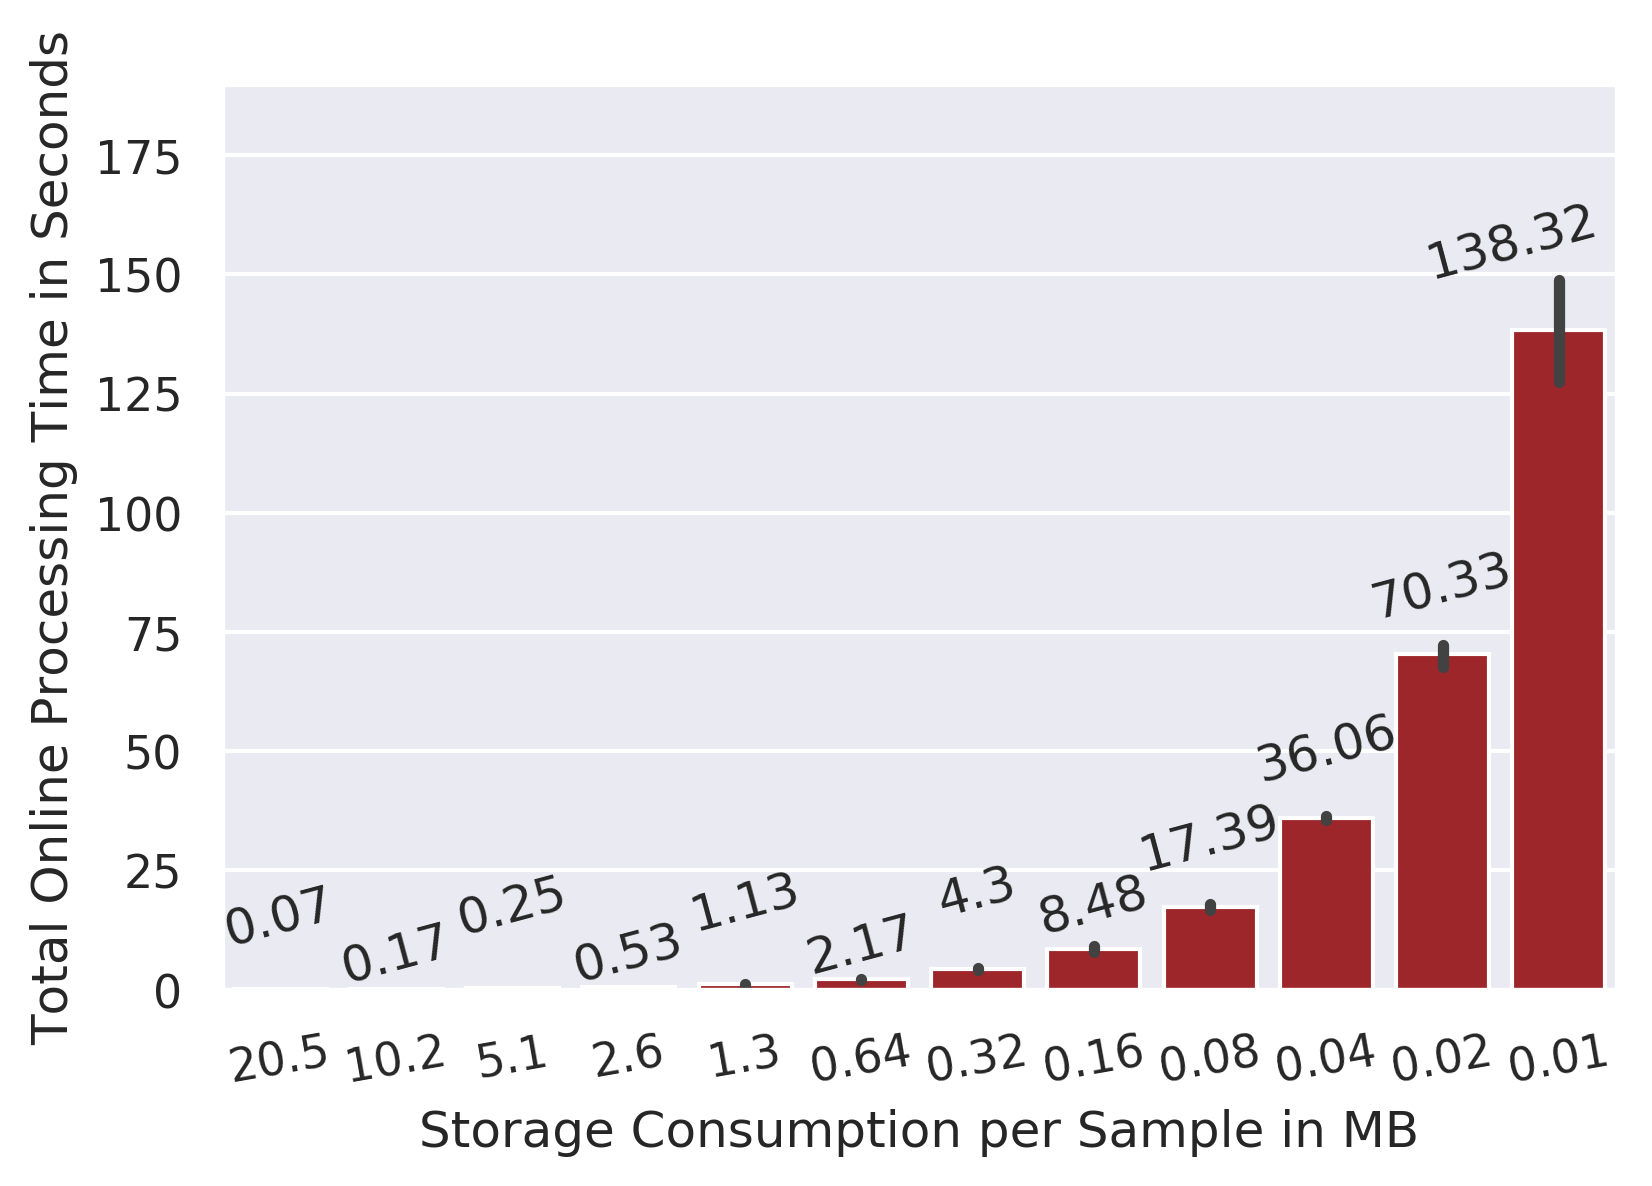

In [17]:
sns.set(palette=sns.color_palette("Reds_r", 5))

storage_consumption_per_samples = list(cum_float32_app_df.query("runs_count==0") \
                                                     .groupby(by='sample_count') \
                                                     .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)
    
sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]

plot = sns.barplot(
    x="sample_count"
   ,y="online_processing_time_s"
   ,hue="runs_count"
   ,data=cum_float32_app_df.query("dtype=='float32'").sort_values(by='sample_count', ascending=True))

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online Processing Time in Seconds")
#plot.legend(title="Epoch", ncol=1, labelspacing=0.1)#, loc=(0.2,0.7))
plt.legend([],[], frameon=False)
show_values_on_bars(plot, h_v="v", space=15, rotation=15, round_to=2,
                   additional_space=[0,-8,2,-8,2,-8,0,-6,0,0,0,5],
                   additional_x_space=[0,0,0,0,0,0,0,0,0,0,0,-0.4]),
plot.set(ylim=(0, 190))


save_fig("artificial-dataset-float-application-caching")

In [18]:
e1_application_level_caching_online_processing_time_s_df = cum_summary_df.query("dtype=='float32' and runs_count==0").sort_values(by='sample_count', ascending=True).groupby(by="sample_count").mean()["online_processing_time_s"]
(e1_system_level_caching_online_processing_time_s_df - e1_application_level_caching_online_processing_time_s_df) / e1_system_level_caching_online_processing_time_s_df


sample_count
732       -2.117135
1464      -2.290869
2929      -2.742352
5859      -2.794855
11718     -3.346237
23437     -2.980732
46875     -2.532032
93750     -1.254630
187500    -0.579018
375000    -0.167278
750000    -0.073089
1500000   -0.037297
Name: online_processing_time_s, dtype: float32

In [19]:
e1_system_level_caching_online_processing_time_s_df

sample_count
732          4.817324
1464         4.463100
2929         4.274098
5859         4.404733
11718        4.599822
23437        5.167854
46875        5.964258
93750       11.200801
187500      20.670221
375000      42.168388
750000      85.478348
1500000    167.275436
Name: online_processing_time_s, dtype: float32

## Batching Analysis

In [20]:
home_path = "../logs/type-logs/float32-batching"
path_to_float32_cum_df = f"{home_path}/type-float32_batching_threads-8_cum-df.csv"
path_to_float32_cum_dstat_df = f"{home_path}/type-float32_batching_threads-8_cum-dstat-df.csv"
float32_dtype = "float32"

cum_float32_df, cum_float32_dstat_df = read_datatype_log(path_to_cum_df = path_to_float32_cum_df
                                                   , path_to_cum_dstat_df = path_to_float32_cum_dstat_df
                                                   , datatype = float32_dtype )
strategies_renamed = ["read-dataset"]
#cum_summary_df = pd.concat([cum_uint8_df, cum_float32_df])
cum_summary_df = pd.concat([cum_float32_df])
cum_summary_df = cum_summary_df.sort_values(by=["sample_count"])

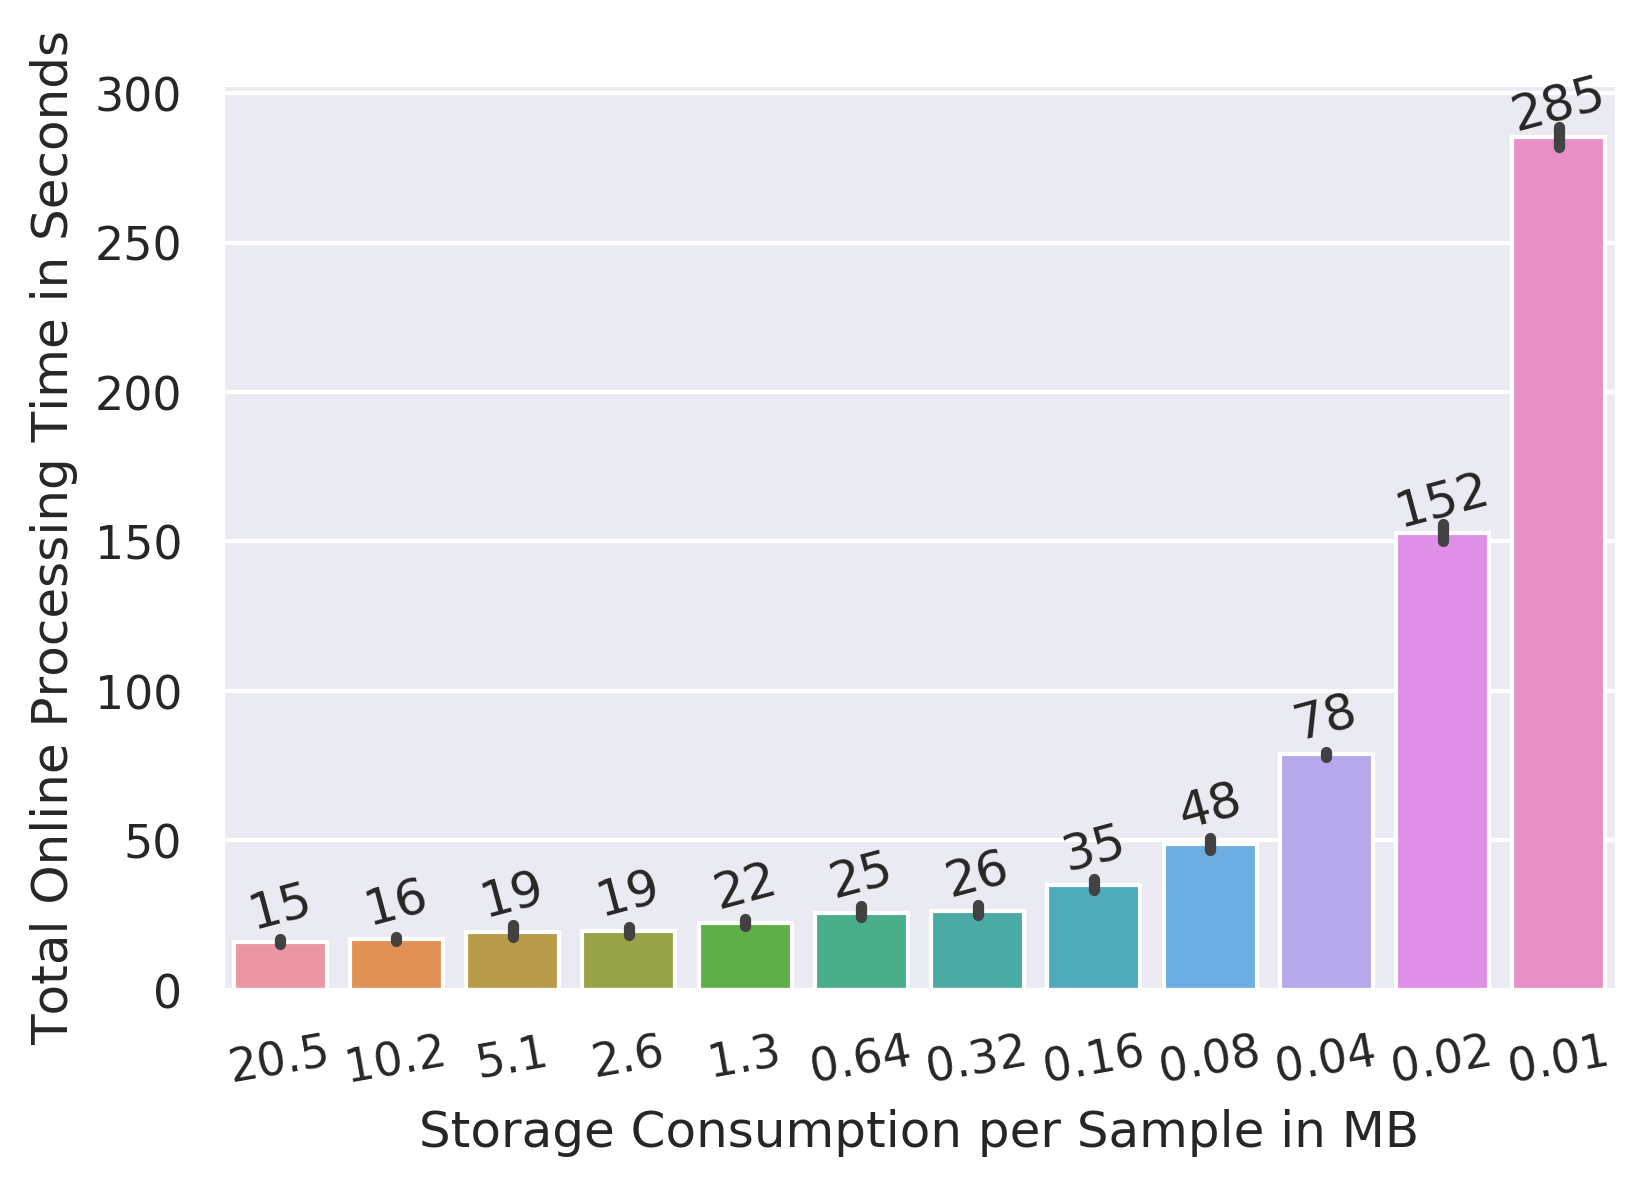

In [21]:
samples_palette = sns.color_palette("icefire", 2)
sns.set(palette=samples_palette)

storage_consumption_per_samples = list(cum_summary_df.query("runs_count==0") \
                                                    .groupby(by='sample_count') \
                                                    .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)
sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]
    
plot = sns.barplot(
    x="sample_count"
   ,y="online_processing_time_s"
   ,data=cum_summary_df.query("runs_count==0"))

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online Processing Time in Seconds")
show_values_on_bars(plot, h_v="v", space=10, rotation=15)
#plot.set(ylim=(0, 190))
#plot.legend(title="DType", ncol=1, labelspacing=0.1)
#save_fig("artificial-dataset")

KeyboardInterrupt: 

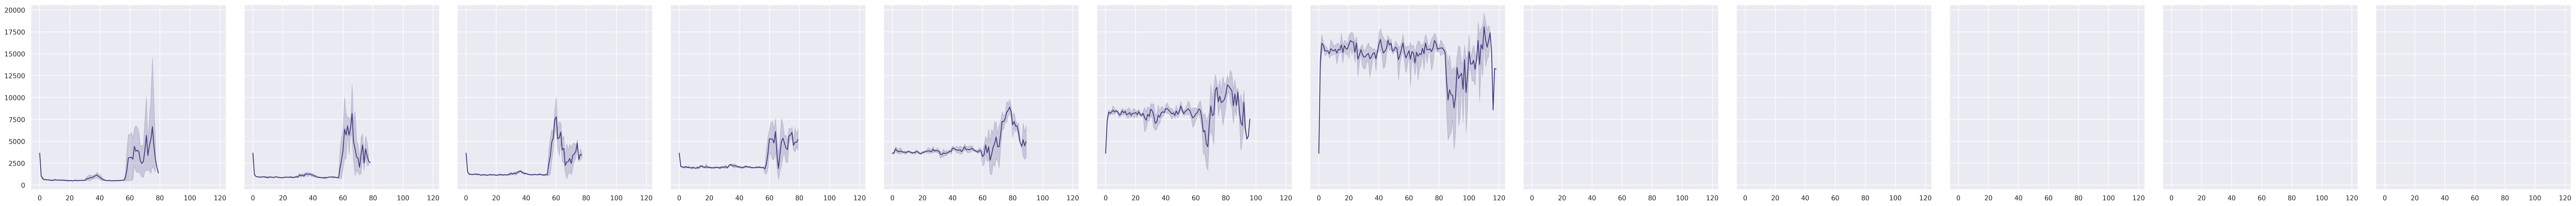

In [22]:
plot = sns.relplot(
    x="rel_time_s",
    y="system_context_switches_per_s",
    col="sample_count",
    kind="line",
    data=cum_float32_dstat_df
)

In [ ]:
extract_online_processing_frames(1500000, df=cum_float32_df, dstat_df=cum_float32_dstat_df).describe()["system_context_switches_per_s"]

## 6. Summary Plots

In [23]:
key = "cache_type"

no_cache_df = cum_float32_sys_df.query("runs_count==0").copy(deep=True)
no_cache_df[key] = "0-no-cache"
sys_cache_df = cum_float32_sys_df.query("runs_count==1").copy(deep=True)
sys_cache_df[key] = "1-sys-cache"
app_cache_df = cum_float32_app_df.query("runs_count==0") # the initial run is already cached due to presto's evaluation
app_cache_df[key] = "2-app-cache"

full_comparison_df = pd.concat([app_cache_df, sys_cache_df, no_cache_df])
full_comparison_df = full_comparison_df.sort_values(by=["sample_count", key])

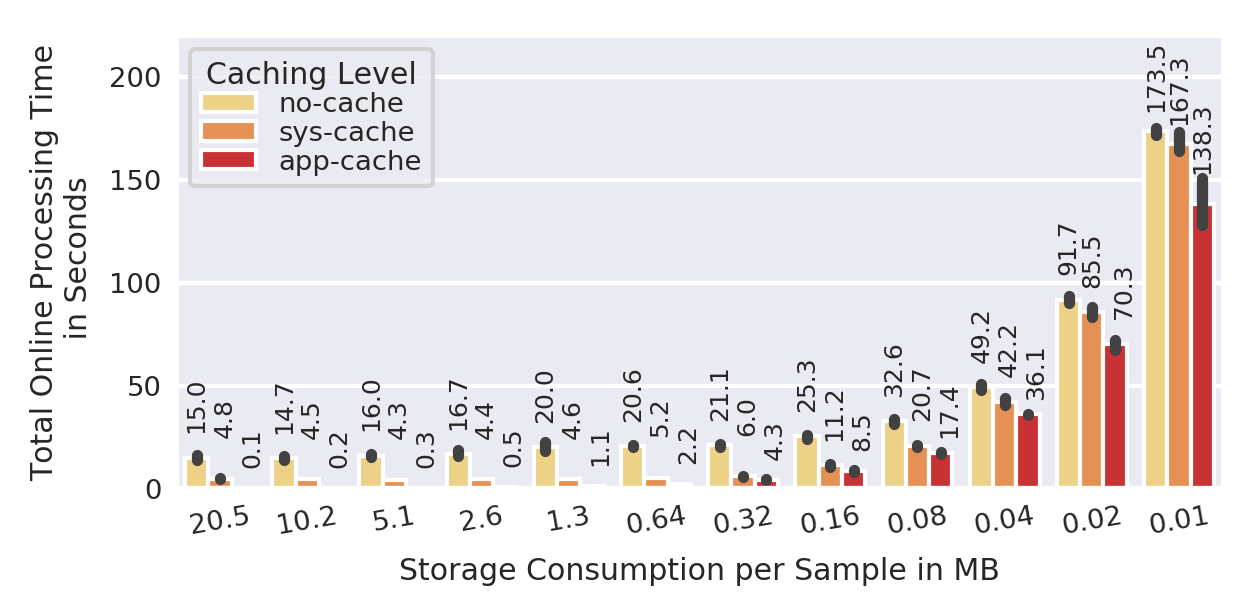

In [24]:
from notebookhelper import show_values_on_bars

sns.set(palette=epoch_palette, font_scale=0.6)

storage_consumption_per_samples = list(full_comparison_df.query("runs_count==0") \
                                                    .groupby(by='sample_count') \
                                                    .mean()["per_sample_size_MB"].round(2))
storage_consumption_per_samples.sort(reverse=True)
def custom_format(label):
    if label > 0.9:
        return str(round(label,1))
    else:
        return str(label)
sc_per_samples_labels = [custom_format(label) for label in storage_consumption_per_samples]

plt.figure(figsize=(4.5,2))

plot = sns.barplot(
    x="sample_count"
   ,y="online_processing_time_s"
   ,hue=key
   ,data=full_comparison_df)

plot.set_xticklabels(
    sc_per_samples_labels
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-2.5)
plot.tick_params(axis='y', which='major', pad=-2.5)
plot.set(ylim=(0, 220))
legend = plot.legend(title="Caching Level", ncol=1, labelspacing=0.1)#, loc=(0.2,0.7))
legend.get_texts()[0].set_text('no-cache')
legend.get_texts()[1].set_text('sys-cache')
legend.get_texts()[2].set_text('app-cache')
plot.set(xlabel="Storage Consumption per Sample in MB", ylabel="Total Online Processing Time\n in Seconds")
show_values_on_bars(plot, h_v="v", space=20, rotation=90, fontsize=6, round_to=1, allowed_index=[24,25,26,27,28,29,30,31,32,33,34,35],
                               additional_x_space=[0,0,0,0,0,0,0,0,0,0,0,0
                                                  ,0,0,0,0,0,0,0,0,0,0,0,0
                                                  ,+0.1,+0.1,+0.1,+0.1,+0.1,+0.1,+0.1,+0.1,+0.1,+0.1,+0.1,0],
                               additional_space=[0,0,0,0,0,0,0,0,0,0,0,0
                                                  ,0,0,0,0,0,0,0,0,0,0,0,0
                                                  ,0,0,0,0,0,0,0,0,5,5,10,20])
show_values_on_bars(plot, h_v="v", space=30, rotation=90, fontsize=6, round_to=1, allowed_index=[12,13,14,15,16,17,18,19,20,21,22,23],
                                                   additional_x_space=[0,0,0,0,0,0,0,0,0,0,0,0
                                                  ,+0.05,+0.05,+0.05,+0.05,+0.05,0.05,0.05,0.05,0.05,0.05,0,0,0,0,0,0,0
                                                  ,0,0,0,0,0,0,0]
                    ,additional_space=[0,0,0,0,0,0,0,0,0,0,0,0
                                      ,0,0,0,0,0,0,0,0,0,0,0,5
                                      ,0,0,0,0,0,0,0,0,0,0,0,0])
show_values_on_bars(plot, h_v="v", space=30, rotation=90, fontsize=6, round_to=1, allowed_index=[0,1,2,3,4,5,6,7,8,9,10,11]
                    ,additional_space=[0,0,0,0,0,0,0,0,0,0,0,5
                                      ,0,0,0,0,0,0,0,0,0,0,0,0
                                      ,0,0,0,0,0,0,0,0,0,0,0,0])
                               #additional_x_space=[0,0,0,0,0,0,0,0,0,0,0,0
                               #                   ,0,0,0,0,0,0,0,0,0,0,0,0
                               #                   ,+0.05,+0.05,+0.05,+0.05,+0.05,0,0,0,0,0,0,0])
save_fig("synthetic-dataset-all-caches")